In [1]:
#Separate notebook to work on Topic Modelling with LDA
%pylab inline
from sys import platform
import pandas as pd

if platform == "win32":
    path = 'C:/Users/olive/'
elif platform == "darwin":
    path = '~/'

Populating the interactive namespace from numpy and matplotlib


In [2]:
c_df = pd.read_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/comments.csv')
s_df = pd.read_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/submissions.csv')

s_df = s_df.sort_values(by='datetime')
c_df = c_df.sort_values(by='datetime')

In [3]:
comments = c_df.reset_index().drop(columns=['id', 'datetime', 'sentiment', 'compound_score', 'submission_id', 'parent_id'], axis=1)

comments = comments.sample(1000)

comments.head()

,body
163672,"Ooohh, had to call back in my day. Might want ..."
183099,I'm not questioning it - I'm happy to see them...
414794,My apologies for the misguided rant.\n\nI was ...
396499,Mh... What you on about ?
40110,Of course I understand why people are unconvin...


In [4]:
# Remove punctuation
import re

comments['processed_text'] = comments['body'].map(lambda x: re.sub('[,\.!?]', '', x))

comments['processed_text'] = comments['processed_text'].map(lambda x: x.lower())

comments['processed_text'].head()

163672    ooohh had to call back in my day might want to...
183099    i'm not questioning it - i'm happy to see them...
414794    my apologies for the misguided rant\n\ni was a...
396499                                mh what you on about 
40110     of course i understand why people are unconvin...
Name: processed_text, dtype: object

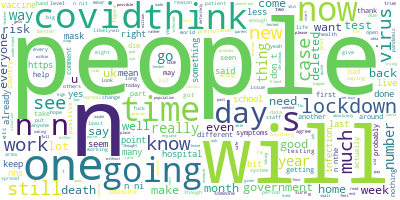

In [5]:
# EXPLORATORY ANALYSIS

from wordcloud import WordCloud

long_string = ','.join(list(comments['processed_text'].values))

wordcloud = WordCloud(background_color="white",
                      max_words=5000,
                      contour_width=3,
                      contour_color='steelblue'
                     )

wordcloud.generate(long_string)

wordcloud.to_image()

In [6]:
# Tokenize words and more text clean-up

import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),
                                            deacc=True))
data = comments.processed_text.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['ooohh', 'had', 'to', 'call', 'back', 'in', 'my', 'day', 'might', 'want', 'to', 'tag', 'op', 'to', 'make', 'sure', 'they', 'see', 'this']


In [ ]:
#Bigram and Trigram Phrase Modelling

bigram = gensim.models.Phrases(data_words, 
                               min_count=5, 
                               threshold=100
                              )
trigram = gensim.models.Phrases(bigram[data_words], 
                                threshold=100
                               )

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [7]:
#Remove Stopwords, Make Bigrams and Lemmantize

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from',
                   'subject', 
                   're', 
                   'edu', 
                   'use'])

In [8]:
#Define functions for stopwords, bigrams, trigrams and lemmatization

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
import spacy

data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load("en_core_web_sm", disable=['parser',
                                            'ner'])

data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[:1])

In [9]:
#Data Tranformation: Corpus and Dictionary

import gensim.corpora as corpora

id2word = corpora.Dictionary(data_words)
# id2word = corpora.Dictionary(data_lemmatized)
texts = data_words
# texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics) 

# Old LDA model
# lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=10) 
#                                        random_state=100,
#                                        chunksize=100,
#                                        passes=10,
#                                        per_word_topics=True)

print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 3), (16, 1)]


In [10]:
from pprint import pprint

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.037*"the" + 0.023*"to" + 0.022*"of" + 0.021*"in" + 0.015*"it" + '
  '0.014*"and" + 0.013*"you" + 0.012*"they" + 0.010*"that" + 0.010*"people"'),
 (1,
  '0.048*"the" + 0.022*"and" + 0.019*"it" + 0.018*"to" + 0.017*"is" + '
  '0.016*"of" + 0.016*"that" + 0.013*"you" + 0.013*"in" + 0.011*"for"'),
 (2,
  '0.048*"the" + 0.040*"to" + 0.019*"and" + 0.015*"of" + 0.010*"you" + '
  '0.010*"in" + 0.010*"it" + 0.009*"be" + 0.009*"for" + 0.008*"is"'),
 (3,
  '0.033*"the" + 0.031*"and" + 0.021*"of" + 0.019*"in" + 0.019*"to" + '
  '0.017*"that" + 0.012*"is" + 0.010*"people" + 0.010*"it" + 0.009*"are"'),
 (4,
  '0.047*"the" + 0.018*"that" + 0.017*"is" + 0.017*"and" + 0.017*"of" + '
  '0.016*"to" + 0.013*"it" + 0.009*"you" + 0.008*"they" + 0.008*"we"'),
 (5,
  '0.038*"to" + 0.033*"the" + 0.020*"and" + 0.020*"is" + 0.019*"that" + '
  '0.015*"of" + 0.014*"it" + 0.012*"in" + 0.011*"have" + 0.009*"not"'),
 (6,
  '0.027*"the" + 0.024*"it" + 0.023*"to" + 0.018*"and" + 0.018*"of" + '
  '0.016*"you" 

In [ ]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)

In [ ]:
# Hyperparameter Tuning
def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=data_lemmatized, 
                                         dictionary=id2word,
                                         coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [11]:
import pyLDAvis.gensim_models
import os
import pickle
import pyLDAvis

pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model,
                                                 corpus,
                                                 id2word
                                                )
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.001644 -0.009778       1        1  21.416060
5      0.024055 -0.001753       2        1  14.125113
9      0.022160 -0.003731       3        1  13.163343
7      0.019863 -0.012110       4        1  12.805016
3     -0.007493  0.005081       5        1   9.375009
2      0.019083  0.011200       6        1   8.920230
0      0.019599  0.011589       7        1   7.992807
6     -0.020248 -0.026784       8        1   5.052772
4     -0.042929 -0.024520       9        1   3.838038
8     -0.032446  0.050804      10        1   3.311612, topic_info=     Term         Freq        Total Category  logprob  loglift
61    the  1398.000000  1398.000000  Default  30.0000  30.0000
47     of   627.000000   627.000000  Default  29.0000  29.0000
15     to  1013.000000  1013.000000  Default  28.0000  28.0000
108   and   762.000000   762.000000  Default  27.0000  27.0000
60   that   497.000000   497.000000  Default  26.0000  26.0000
..    ...          ...          ...      ...      ...      ...
268    no     4.293097   109.399596  Topic10  -5.6678   0.1697
67    was     4.629681   149.847427  Topic10  -5.5923  -0.0694
283  will     4.568582   147.697365  Topic10  -5.6056  -0.0682
45    not     5.011781   257.572722  Topic10  -5.5130  -0.5318
40     it     4.700671   585.341837  Topic10  -5.5771  -1.4168

[803 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2886      4  0.568876  abergele
82        1  0.227891     about
82        2  0.135047     about
82        3  0.109725     about
82        4  0.143487     about
...     ...       ...       ...
104       7  0.153062      your
104       8  0.066965      your
104       9  0.038265      your
104      10  0.009566      your
2811      5  0.628880   youtube

[1547 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 10, 8, 4, 3, 1, 7, 5, 9])

In [ ]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

#Can take a while to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], 
                                                  dictionary=id2word, 
                                                  k=k, 
                                                  a=a,
                                                  b=b)
                    print('Alert')
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
                    
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv',
                                       index=False)
    pbar.close()
